<a href="https://colab.research.google.com/github/AeMcRa/Datascience-things/blob/main/AedaRamosU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

# Brain Weight vs Head Size

It would make sense that larger heads correspond with heavier brains, but lets make a model to make sure.

I grabbed some data that contains head sizes and brain weights of various individuals.

In [ ]:
#load the data into a pandas dataframe, and print it
url_brain = 'https://raw.githubusercontent.com/AeMcRa/Datascience-things/refs/heads/main/BrainHead.csv'
#I could have put the url string directly into pd.read_csv()
brain = pd.read_csv(url_brain)

In [ ]:
brain

,BrainWeight,HeadSize
0,4512,1530
1,3738,1297
2,4261,1335
3,3777,1282
4,4177,1590
...,...,...
232,3214,1110
233,3394,1215
234,3233,1104
235,3352,1170


# Preliminary scatterplot

Text(0, 0.5, 'Brain Weight(g)')

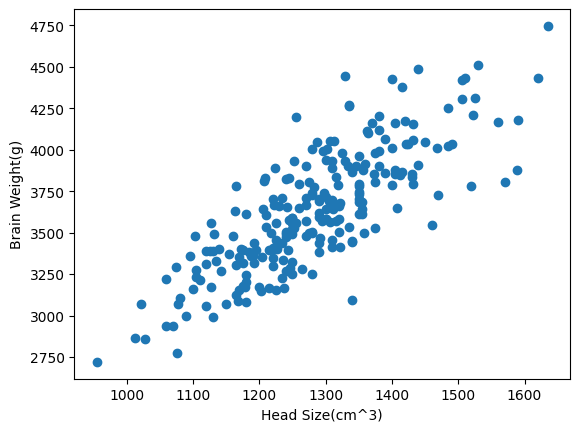

In [ ]:
#make scatter plot of brain weight vs head size
plt.scatter(brain["HeadSize"], brain["BrainWeight"] )

#label axes

plt.xlabel("Head Size(cm^3)")
plt.ylabel("Brain Weight(g)")

# Analysis
It seems relatively regular with a clear trend. The values are relatively tight and regular across an inferenced mean line, so I will use a normal distribution for my model. Since I have little knowledge about this field, I am using quite weak priors.

In [ ]:
#lb stands for linear bike
with pm.Model() as model_lb:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    α_two = pm.Normal("α_two", mu=0, sigma=20)
    β_two = pm.Normal("β_two", mu=0, sigma=5)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * brain.HeadSize)
    σ = pm.Deterministic("σ", α_two + β_two * brain.HeadSize)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    #σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=brain.BrainWeight)

    #inference data object
    idata_lb = pm.sample()


Output()

Output()

In [ ]:
pm.sample_posterior_predictive(
    idata_lb, model = model_lb, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

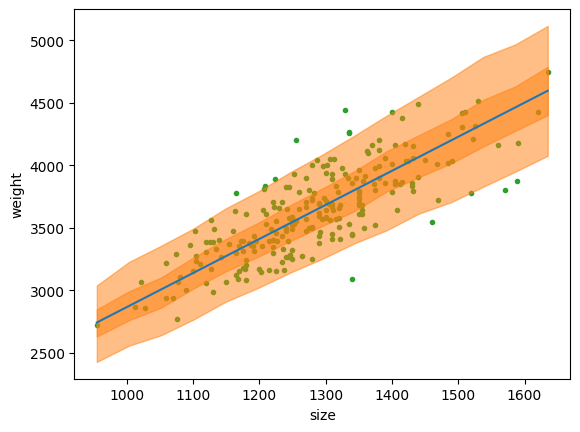

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lb.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
size = np.random.normal(brain.HeadSize.values, 0.01)
idx = np.argsort(size)
x = np.linspace(size.min(), size.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(size[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(brain.HeadSize, brain.BrainWeight, "C2.", zorder=-3)
ax.plot(brain.HeadSize[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("size")
ax.set_ylabel("weight")

# Looks pretty solid, if boring
Lets check our predicted posterior

<Axes: xlabel='y_pred'>

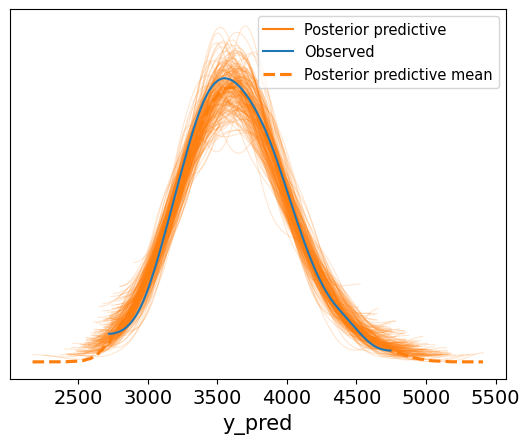

In [ ]:
az.plot_ppc(idata_lb, num_pp_samples=200, colors=["C1", "C0", "C1"])

# Looks good!
But this is boring and I want to try some other cool stuff. Head size of adults is frankly quite limited, as there aren't many people with very large or small heads. That is, except for children:



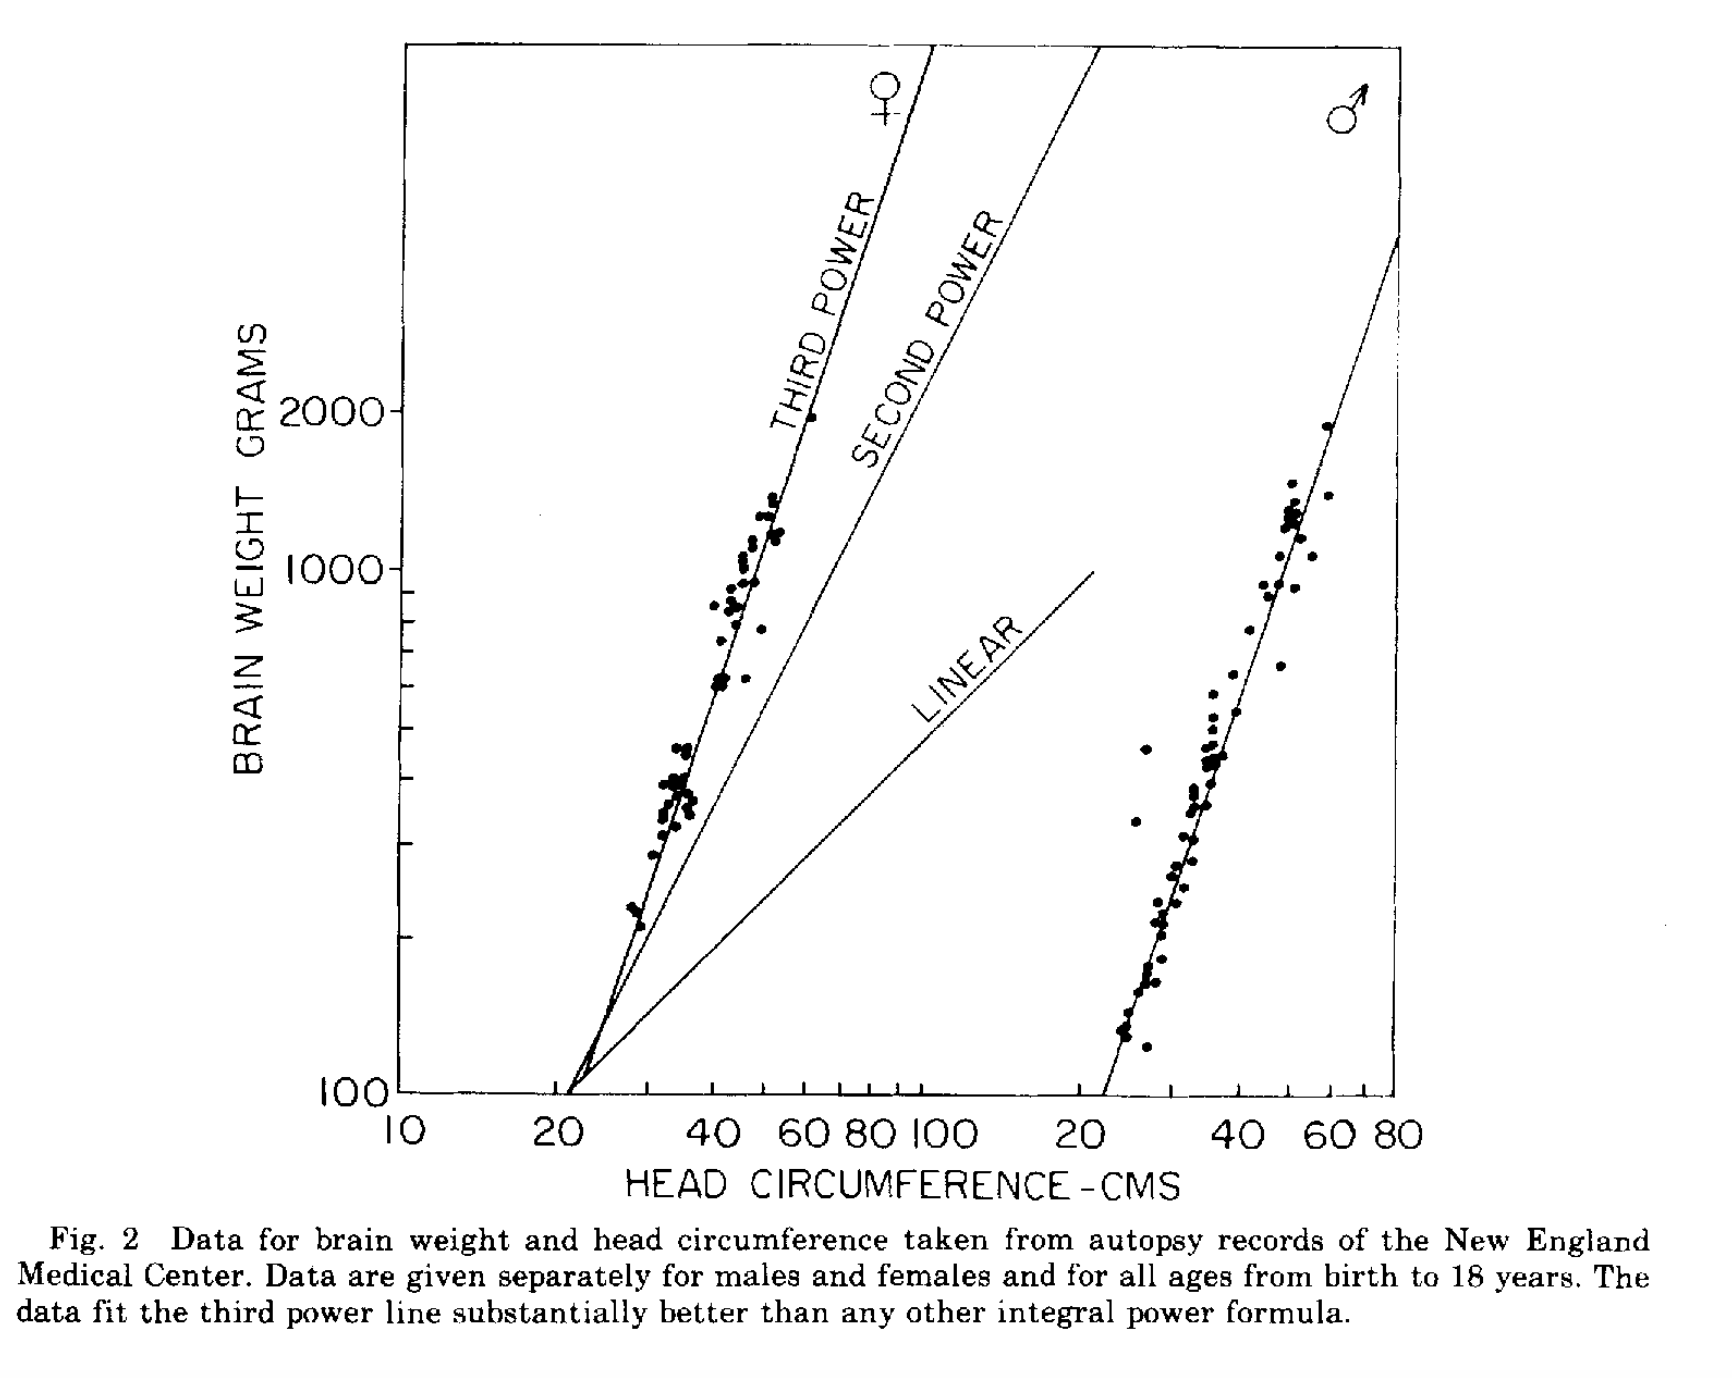

# Analysis
Here is some data of children's head size vs brain weight. As we can see, it is much steeper as compared to the other data. This would suggest that the data should follow some sort of logarithmic curve. Note that the data above is from autopsy reports, and as such likely skews data as dead children usually have issues.

In [ ]:
#glb stands for generalized linear brain
with pm.Model() as model_glb:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    α_two = pm.Normal("α_two", mu=0, sigma=20)
    β_two = pm.Normal("β_two", mu=0, sigma=5)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * brain.HeadSize)
    σ = pm.Deterministic("σ", α_two + β_two * brain.HeadSize)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    #σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.LogNormal("y_pred", mu=μ, sigma=σ, observed=brain.BrainWeight)

    #inference data object
    idata_glb = pm.sample()

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(
    idata_glb, model = model_glb, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

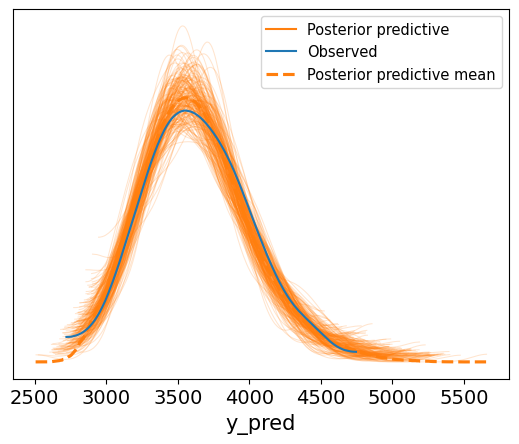

In [ ]:
az.plot_ppc(idata_glb, num_pp_samples=200, colors=["C1", "C0", "C1"])

# Analysis
Slightly less accurate, but that tracks because we are extrapolating ideas about data that is not present in the model. Lets look at the general linear model to see if this is actually what we want.

Text(0, 0.5, 'weight')

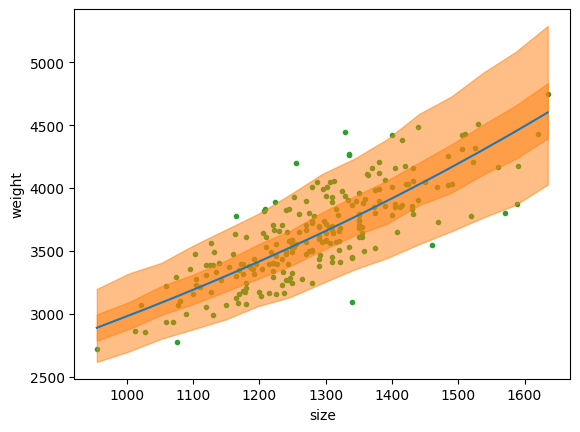

In [ ]:


#ANSWER5 cont.

mean_line = idata_glb.posterior["μ"].mean(("chain", "draw"))
size = np.random.normal(brain.HeadSize.values, 0.01)
idx = np.argsort(size)
x = np.linspace(size.min(), size.max(), 15)
y_pred_q = idata_glb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(size[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(brain.HeadSize, brain.BrainWeight, "C2.", zorder=-3)
ax.plot(brain.HeadSize[idx], np.exp(mean_line[idx]), c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("size")
ax.set_ylabel("weight")

# Analysis & conclusion
This is definitly not logarithmic. If anything, it looks exponential. I think the lack of data skews what our graph looks like.

It seems that, at least for adults, the weight of the brain linearly scales with head size. It is likely different for children, as well as on a scale with both adults and children, but unfortunately we do not have enough data to deterime any such difference at this time. As noted earlier, the data from children is specifically from dead children's autopsy reports, and dead children usually have problems with them that might affect their head size and brain weight, so we must take that data with a grain of salt. Thus we conclude:
Brain weight is linearly correlated with head size.